## Limit Order Books - Implementation

---

We aim to implement an minimally algorithmically efficient LOB. 

Complexity:
* Insertion: $O(\log n)$ insertion on first order at limit, $O(1)$ otherwise
* Cancellation: $O(1)$
* Execute: $O(1)$
* Get Volume at price $x$: $O(1)$
* Get best bid/offer: $O(1)$

No considerations on thread safety / async / latency made.

## Implementation

In [1]:
import logging
import math
import time
from dataclasses import dataclass, field
from datetime import datetime
from enum import Enum, auto
from typing import Any, Callable, Dict, List, Optional, Tuple

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
from sortedcontainers import SortedDict

from theoria.validor import TestCase, Validor

In [2]:
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
if not log.hasHandlers():
    handler = logging.StreamHandler()
    handler.setFormatter(logging.Formatter("[%(asctime)s] [%(levelname)s] %(message)s"))
    log.addHandler(handler)

In [3]:
class Side(Enum):
    BID = auto()
    ASK = auto()


@dataclass
class Order:
    order_id: int
    side: Side
    price: float
    qty: int
    index: int  # index in Level.orders
    timestamp: float

    def __repr__(self) -> str:
        return f"Order(id={self.order_id}, side={self.side.name}, price={self.price}, qty={self.qty}, ts={datetime.fromtimestamp(self.timestamp)})"


@dataclass
class Level:
    total_qty: int

    # O(1) insert/remove within level
    orders: List[Order] = field(default_factory=list)


class SideBook:
    def __init__(self, side: Side):
        self.side = side

        # Price -> Level
        # Keys kept sorted with O(log n) insert/remove using SortedDict (Red-Black Tree)
        # Once inserted, O(1) insert/remove within levels
        self.levels: SortedDict[float, Level] = SortedDict()

    def best_price(self) -> Optional[float]:
        if not self.levels:
            return None

        # max for bids, min for asks
        return (
            self.levels.peekitem(-1)[0]
            if self.side is Side.BID
            else self.levels.peekitem(0)[0]
        )

In [ ]:
class OrderBook:
    def __init__(
        self,
        on_insert: Optional[Callable[[Order], Any]] = None,
        on_cancel: Optional[Callable[[Order], Any]] = None,
        # on_fill(order_id, price, qty, timestamp)
        on_fill: Optional[Callable[[int, float, int, float], Any]] = None,
    ):
        self.bids = SideBook(Side.BID)
        self.asks = SideBook(Side.ASK)
        self.orders_by_id: Dict[int, Order] = {}

        self.on_insert = on_insert
        self.on_cancel = on_cancel
        self.on_fill = on_fill

    def _side_book(self, side: Side) -> SideBook:
        return self.bids if side is Side.BID else self.asks

    def _remove_from_level(self, order: Order) -> None:
        """O(1) removal using swap-with-last; may delete empty price level."""
        sb = self._side_book(order.side)
        level = sb.levels[order.price]

        idx = order.index
        last_idx = len(level.orders) - 1
        last_order = level.orders[last_idx]

        if idx != last_idx:
            level.orders[idx] = last_order
            last_order.index = idx

        level.orders.pop()
        level.total_qty -= order.qty

        if level.total_qty <= 0:
            del sb.levels[order.price]

    def _match_against(
        self, taker_side: Side, limit_price: float, qty: int, timestamp: float
    ) -> Optional[int]:
        """
        Internal matching engine:
        - taker_side is the side of the incoming order (BID/ASK)
        - matched price is at best opposite price level
        - it trades against the *opposite* book up to limit_price
        - qty is mutated locally (remaining quantity to match)
        """
        if qty <= 0:
            return

        # Taker BID hits asks; taker ASK hits bids
        if taker_side is Side.BID:
            opposite_book = self.asks

            def price_crosses(best_price: float) -> bool:
                return best_price <= limit_price
        else:
            opposite_book = self.bids

            def price_crosses(best_price: float) -> bool:
                return best_price >= limit_price

        while qty > 0:
            best_price = opposite_book.best_price()
            if best_price is None or not price_crosses(best_price):
                break

            level = opposite_book.levels[best_price]
            if not level.orders:
                del opposite_book.levels[best_price]
                continue

            # FIFO at this price level
            maker = level.orders[0]

            trade_qty = min(qty, maker.qty)
            maker.qty -= trade_qty
            level.total_qty -= trade_qty
            qty -= trade_qty

            if self.on_fill is not None:
                self.on_fill(maker.order_id, maker.price, trade_qty, timestamp)

            # Fully filled: remove from structures
            if maker.qty == 0:
                self.orders_by_id.pop(maker.order_id, None)
                self._remove_from_level(maker)

        return qty

    # ---------- API ----------

    def insert(
        self,
        order_id: int,
        side: Side,
        price: float,
        qty: int,
        timestamp: Optional[float] = None,
    ) -> None:
        """
        Insert a new order.
        - If it is marketable (crosses the spread), it first *executes*
          against the opposite book up to its limit price.
        - Any remaining qty is then added as a resting order.
        First order at a new price: O(log n). Subsequent at same price: O(1).
        """
        if order_id in self.orders_by_id:
            raise ValueError("duplicate order_id")

        # Match aggressively against opposite side
        ts = timestamp if timestamp is not None else time.time()
        remaining = self._match_against(
            side,
            price,
            qty,
            ts,
        )

        # If anything is left, rest it in the book
        if remaining and remaining > 0:
            sb = self._side_book(side)
            level = sb.levels.get(price)
            if level is None:
                level = Level(total_qty=0, orders=[])
                sb.levels[price] = level

            index = len(level.orders)
            ts = time.time() if timestamp is None else timestamp
            order = Order(
                order_id=order_id,
                side=side,
                price=price,
                qty=remaining,
                index=index,
                timestamp=ts,
            )

            level.orders.append(order)
            level.total_qty += remaining
            self.orders_by_id[order_id] = order

            if self.on_insert is not None:
                self.on_insert(order)

    def cancel(self, order_id: int) -> None:
        """
        O(1) average via ID lookup + O(1) level removal.
        """
        order = self.orders_by_id.pop(order_id, None)
        if order is None:
            return

        self._remove_from_level(order)

        if self.on_cancel is not None:
            self.on_cancel(order)

    def get_volume_at_price(self, side: Side, price: float) -> int:
        """
        O(1) lookup.
        Return total quantity at given price level on given side.
        0 if no such level.
        """
        sb = self._side_book(side)
        level = sb.levels.get(price)
        return level.total_qty if level else 0

    def best_bid(self) -> Optional[Tuple[float, int]]:
        """
        O(1) lookup.
        Return (price, total_qty) of best bid, or None if no bids.
        """
        price = self.bids.best_price()
        if price is None:
            return None
        level = self.bids.levels[price]
        return price, level.total_qty

    def best_ask(self) -> Optional[Tuple[float, int]]:
        """
        O(1) lookup.
        Return (price, total_qty) of best ask, or None if no asks.
        """
        price = self.asks.best_price()
        if price is None:
            return None
        level = self.asks.levels[price]
        return price, level.total_qty

## Tests

In [5]:
test_cases = [
    TestCase(
        input_data={
            "operations": [
                (
                    "insert",
                    {"order_id": 1, "side": Side.BID, "price": 100.0, "qty": 10},
                ),
                ("insert", {"order_id": 2, "side": Side.ASK, "price": 101.0, "qty": 5}),
                (
                    "insert",
                    {"order_id": 3, "side": Side.BID, "price": 100.0, "qty": 15},
                ),
                (
                    "insert",
                    {"order_id": 4, "side": Side.ASK, "price": 100.5, "qty": 10},
                ),
            ],
        },
        expected_output={
            "best_bid": (100.0, 25),
            "best_ask": (100.5, 10),
        },
        description="Basic insertions without matching",
    ),
    TestCase(
        input_data={
            "operations": [
                ("insert", {"order_id": 1, "side": Side.BID, "price": 99.0, "qty": 20}),
                (
                    "insert",
                    {"order_id": 2, "side": Side.ASK, "price": 100.0, "qty": 10},
                ),
                (
                    "insert",
                    {"order_id": 3, "side": Side.BID, "price": 100.0, "qty": 5},
                ),  # Matches
            ],
        },
        expected_output={
            "best_bid": (99.0, 20),
            "best_ask": (100.0, 5),
        },
        description="Insertion with matching against existing orders",
    ),
    TestCase(
        input_data={
            "operations": [
                ("insert", {"order_id": 1, "side": Side.BID, "price": 97.0, "qty": 10}),
                ("insert", {"order_id": 2, "side": Side.ASK, "price": 98.0, "qty": 10}),
                (
                    "insert",
                    {"order_id": 3, "side": Side.BID, "price": 99.0, "qty": 20},
                ),  # Matches
                (
                    "insert",
                    {"order_id": 4, "side": Side.ASK, "price": 96.0, "qty": 5},
                ),  # Matches
            ],
        },
        expected_output={
            "best_bid": (99.0, 5),
            "best_ask": None,
        },
        description="Multiple matching orders, matching via opposite price",
    ),
    TestCase(
        input_data={
            "operations": [
                ("insert", {"order_id": 1, "side": Side.BID, "price": 98.0, "qty": 30}),
                ("cancel", {"order_id": 1}),
                ("insert", {"order_id": 2, "side": Side.ASK, "price": 99.0, "qty": 15}),
            ],
        },
        expected_output={
            "best_bid": None,
            "best_ask": (99.0, 15),
        },
        description="Cancellation of an existing order",
    ),
    TestCase(
        input_data={
            "operations": [
                (
                    "insert",
                    {"order_id": 1, "side": Side.BID, "price": 100.0, "qty": 10},
                ),
                ("insert", {"order_id": 2, "side": Side.BID, "price": 100.0, "qty": 5}),
                (
                    "insert",
                    {"order_id": 3, "side": Side.ASK, "price": 101.0, "qty": 20},
                ),
                (
                    "insert",
                    {"order_id": 4, "side": Side.ASK, "price": 102.0, "qty": 15},
                ),
            ],
        },
        expected_output={
            "volume_at_bid_price_100.0": {(Side.BID, 100.0): 15},
            "volume_at_ask_price_101.0": {(Side.ASK, 101.0): 20},
            "volume_at_ask_price_102.0": {(Side.ASK, 102.0): 15},
        },
    ),
]


def run_lob_test(operations: List[Tuple[str, Dict]]) -> OrderBook:
    book = OrderBook()

    for op_name, params in operations:
        fn = getattr(book, op_name)
        fn(**params)

    return book


def compare_results(actual: OrderBook, expected: Dict) -> bool:
    if "best_bid" in expected:
        if actual.best_bid() != expected["best_bid"]:
            return False
    if "best_ask" in expected:
        if actual.best_ask() != expected["best_ask"]:
            return False
    if "volume" in expected:
        for (side, price), vol in expected["volume"].items():
            if actual.get_volume_at_price(side, price) != vol:
                return False
    return True


Validor(run_lob_test).add_cases(test_cases).run(compare_results)

[2025-12-28 16:37:06,451] [INFO] All 5 tests passed for run_lob_test.


## Visualization

In [6]:
@dataclass
class TradeEvent:
    price: float
    qty: float
    visible: bool
    timestamp: float


@dataclass
class LevelSnapshot:
    t: float
    bid_levels: List[Optional[float]]
    ask_levels: List[Optional[float]]
    trades: List[TradeEvent] = field(default_factory=list)


class Recorder:
    def __init__(self, book: "OrderBook", k: int = 5):
        """
        Record top-k levels of the order book over time.

        Used to visualize and analyze order book dynamics and trade events.
        """
        self.book = book
        self.k = k
        self.events: List[LevelSnapshot] = []
        self._current_snapshot: Optional[LevelSnapshot] = None

    # TODO: improve complexity - but just for recording so far it's acceptable
    def _top_k_prices(self) -> Tuple[List[Optional[float]], List[Optional[float]]]:
        bid_prices = sorted(self.book.bids.levels.keys(), reverse=True)
        bid_levels = [
            bid_prices[i] if i < len(bid_prices) else math.nan for i in range(self.k)
        ]

        ask_prices = sorted(self.book.asks.levels.keys())
        ask_levels = [
            ask_prices[i] if i < len(ask_prices) else math.nan for i in range(self.k)
        ]
        return bid_levels, ask_levels

    def record_book(self, t: Optional[float] = None) -> None:
        if t is None:
            t = time.time()

        bids, asks = self._top_k_prices()
        self._current_snapshot = LevelSnapshot(t=t, bid_levels=bids, ask_levels=asks)
        self.events.append(self._current_snapshot)

    def record_trade(
        self,
        price: float,
        qty: float,
        visible: bool = True,
        t: Optional[float] = None,
    ) -> None:
        if self._current_snapshot is None:
            self.record_book()
        if t is None:
            t = time.time()

        trade = TradeEvent(price=price, qty=qty, visible=visible, timestamp=t)
        self._current_snapshot.trades.append(trade)

    def plot(self) -> None:
        if not self.events:
            return

        K = self.k
        events = self.events

        raw_ts = [e.t for e in events]
        ts = [datetime.fromtimestamp(t) for t in raw_ts]

        bid_series = [[e.bid_levels[k] for e in events] for k in range(K)]
        ask_series = [[e.ask_levels[k] for e in events] for k in range(K)]

        fig, ax = plt.subplots(figsize=(14, 6))

        # --- Book paths ---
        for k in range(K):
            bs = bid_series[k]
            as_ = ask_series[k]

            if all(math.isnan(x) for x in bs) and all(math.isnan(x) for x in as_):
                continue

            alpha = max(0.55, 0.90 - 0.05 * k)

            ax.step(
                ts,
                bs,
                where="post",
                color="forestgreen",
                lw=0.8,
                alpha=alpha,
                label="Bid" if k == 0 else None,
            )
            ax.step(
                ts,
                as_,
                where="post",
                color="firebrick",
                lw=0.8,
                alpha=alpha,
                label="Ask" if k == 0 else None,
            )

        # --- Trades ---
        trade_ts, trade_px = [], []

        for e in events:
            for tr in e.trades:
                t_trade = datetime.fromtimestamp(tr.timestamp)
                trade_ts.append(t_trade)
                trade_px.append(tr.price)

        if trade_ts:
            ax.scatter(
                trade_ts,
                trade_px,
                s=50,
                color="black",
                marker="o",
                zorder=5,
                label="Matched Trade (Executed)",
            )

        ax.set_xlabel("Time")
        ax.set_ylabel("Price")
        ax.set_title(
            f"Top {K} Bid/Ask Levels and Trades Over Time (Trades: {len(trade_ts)})"
        )
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
        fig.autofmt_xdate()

        ax.grid(True, alpha=0.25)
        ax.legend(loc="upper right", title="Trade Type")
        plt.tight_layout()
        plt.show()

## Example Simulation

[2025-12-28 16:44:53,561] [INFO] Filled: order_id=3, price=100.75, qty=1, timestamp=2025-12-28 16:44:56.561082
[2025-12-28 16:44:53,564] [INFO] Filled: order_id=6, price=101.25, qty=3, timestamp=2025-12-28 16:45:03.561082
[2025-12-28 16:44:53,566] [INFO] Filled: order_id=11, price=101.25, qty=1, timestamp=2025-12-28 16:45:04.561082
[2025-12-28 16:44:53,569] [INFO] Filled: order_id=16, price=101.5, qty=1, timestamp=2025-12-28 16:45:37.561082
[2025-12-28 16:44:53,571] [INFO] Filled: order_id=14, price=101.5, qty=1, timestamp=2025-12-28 16:45:37.561082
[2025-12-28 16:44:53,573] [INFO] Filled: order_id=14, price=101.5, qty=1, timestamp=2025-12-28 16:45:39.561082
[2025-12-28 16:44:53,576] [INFO] Filled: order_id=18, price=101.75, qty=4, timestamp=2025-12-28 16:45:45.561082
[2025-12-28 16:44:53,578] [INFO] Filled: order_id=40, price=101.75, qty=2, timestamp=2025-12-28 16:45:45.561082
[2025-12-28 16:44:53,579] [INFO] Filled: order_id=20, price=102.0, qty=4, timestamp=2025-12-28 16:45:52.56108

[2025-12-28 16:44:53,619] [INFO] Filled: order_id=115, price=103.0, qty=10, timestamp=2025-12-28 16:46:48.561082
[2025-12-28 16:44:53,626] [INFO] Filled: order_id=116, price=103.0, qty=5, timestamp=2025-12-28 16:46:52.561082
[2025-12-28 16:44:53,630] [INFO] Filled: order_id=116, price=103.0, qty=5, timestamp=2025-12-28 16:46:54.561082
[2025-12-28 16:44:53,631] [INFO] Filled: order_id=122, price=103.0, qty=4, timestamp=2025-12-28 16:46:55.561082
[2025-12-28 16:44:53,633] [INFO] Filled: order_id=123, price=103.0, qty=11, timestamp=2025-12-28 16:46:57.561082
[2025-12-28 16:44:53,634] [INFO] Filled: order_id=78, price=103.25, qty=9, timestamp=2025-12-28 16:47:02.561082
[2025-12-28 16:44:53,636] [INFO] Filled: order_id=118, price=103.25, qty=6, timestamp=2025-12-28 16:47:02.561082
[2025-12-28 16:44:53,640] [INFO] Filled: order_id=64, price=103.5, qty=12, timestamp=2025-12-28 16:47:09.561082
[2025-12-28 16:44:53,643] [INFO] Filled: order_id=132, price=103.5, qty=7, timestamp=2025-12-28 16:47

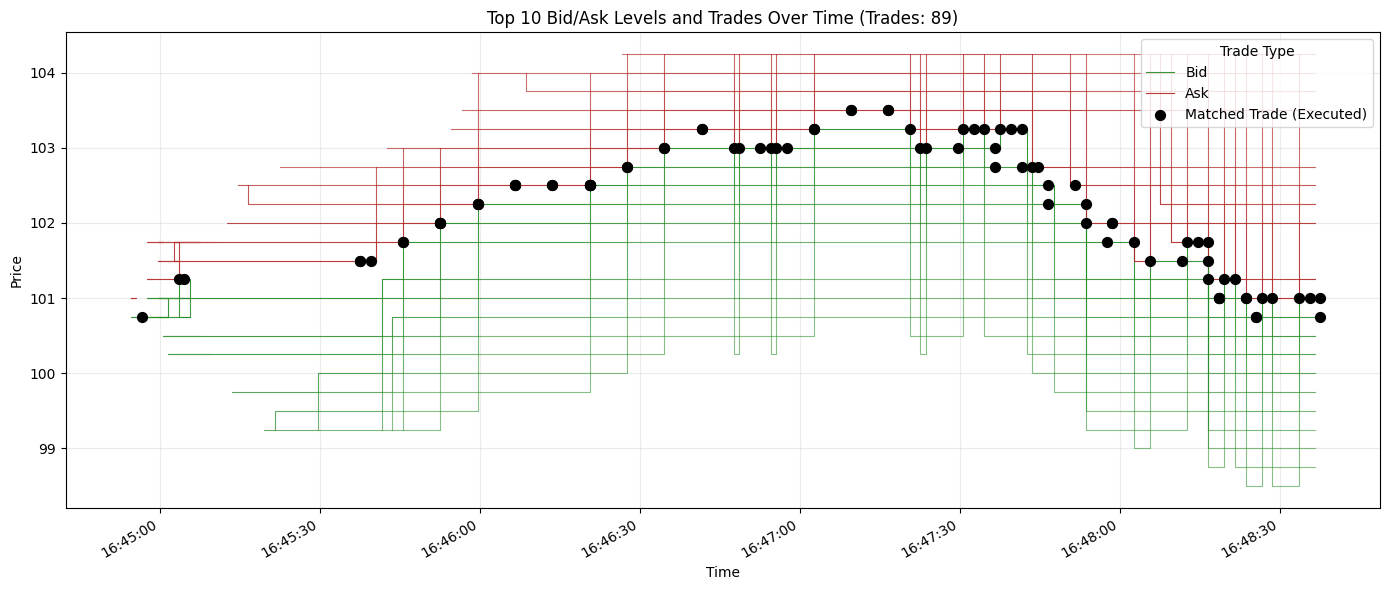

In [17]:
class SimState:
    def __init__(self, t0: float, bid0: float, ask0: float, tick: float):
        self.t = t0
        self.bid_px = bid0
        self.ask_px = ask0
        self.tick = tick

    def advance_time(self, dt: float = 1.0):
        self.t += dt

    def next_bid_price(self):
        step = np.random.randint(-2, 3)
        self.bid_px += step * self.tick
        return self.bid_px

    def next_ask_price(self):
        step = np.random.randint(-2, 3)
        self.ask_px += step * self.tick
        return self.ask_px


def auto_id():
    oid = 0
    while True:
        oid += 1
        yield oid


if __name__ == "__main__":
    np.random.seed(42)

    book = OrderBook()
    rec = Recorder(book, k=10)
    id_gen = auto_id()

    # --- Callbacks ---
    def on_insert(order: Order) -> None:
        rec.record_book(t=order.timestamp)
        log.debug(f"Inserted: {order}")

    def on_cancel(order: Order) -> None:
        rec.record_book(t=order.timestamp)
        log.debug(f"Cancelled: {order}")

    def on_fill(oid: int, price: float, qty: int, ts: float) -> None:
        rec.record_trade(price=price, qty=qty, visible=True, t=ts)
        log.info(
            f"Filled: order_id={oid}, price={price}, qty={qty}, timestamp={datetime.fromtimestamp(ts)}"
        )

    book.on_insert = on_insert
    book.on_cancel = on_cancel
    book.on_fill = on_fill

    # --- Simulation ---

    tick_size = 0.25
    state = SimState(t0=time.time(), bid0=100.0, ask0=101.0, tick=tick_size)

    def insert_bid(qty: int):
        price = state.next_bid_price()
        book.insert(
            order_id=next(id_gen),
            side=Side.BID,
            price=price,
            qty=qty,
            timestamp=state.t,
        )
        state.advance_time()

    def insert_ask(qty: int):
        price = state.next_ask_price()
        book.insert(
            order_id=next(id_gen),
            side=Side.ASK,
            price=price,
            qty=qty,
            timestamp=state.t,
        )
        state.advance_time()

    def sweep_ask(qty: int):
        """Aggressive buy: hit current best ask (Market Order)."""
        best_ask = book.best_ask()
        if best_ask is None:
            return

        price = best_ask[0]
        book.insert(
            order_id=next(id_gen),
            side=Side.BID,
            price=price,
            qty=qty,
            timestamp=state.t,
        )
        state.advance_time()

    for i in range(25):
        insert_bid(qty=np.random.randint(1, 5))
        if i < 10:
            book.cancel(order_id=i + 1)

        insert_ask(qty=np.random.randint(1, 5))

    for i in range(75):
        insert_bid(qty=np.random.randint(5, 20))
        insert_ask(qty=np.random.randint(5, 20))

        # Every 3rd iteration, do an aggressive buy
        if i % 3 == 0:
            sweep_ask(qty=np.random.randint(10, 25))

    rec.plot()

## References

https://github.com/Kautenja/limit-order-book/blob/master/notes/lob.md